In [61]:
import xarray as xr
from dask.distributed import Client
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import cosima_cookbook as cc


In [4]:
client = Client(n_workers=16)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38207 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38207/status,
Dashboard: /proxy/38207/status,Workers: 16
Total threads: 32,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40229,Workers: 16
Dashboard: /proxy/38207/status,Total threads: 32
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:33799,Total threads: 2
Dashboard: /proxy/45511/status,Memory: 15.70 GiB
Nanny: tcp://127.0.0.1:33785,


In [5]:
regimes_monthly = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask.nc')
regimes_time_mean = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')

In [ ]:
chunk = {'yu_ocean':52, 'xu_ocean':1200}
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')
# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

In [63]:
# Select data in the southern Southern Ocean
lat_slice  = slice(-80, -59)

# Load database
#session = cc.database.create_session('/g/data/ik11/databases/ryf9091.db')
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'
# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

In [89]:
# Custom colormap
import matplotlib
colorsList_no3 = [('mediumseagreen'),('tomato'),('blueviolet')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)


In [90]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

In [91]:
ASC_regimes = regimes_time_mean.regimes_mask.where(~np.isnan(regimes_time_mean.regimes_mask),0).isel(regime=0).values+\
regimes_time_mean.regimes_mask.where(~np.isnan(regimes_time_mean.regimes_mask),0).isel(regime=1).values*2+\
regimes_time_mean.regimes_mask.where(~np.isnan(regimes_time_mean.regimes_mask),0).isel(regime=2).values*3

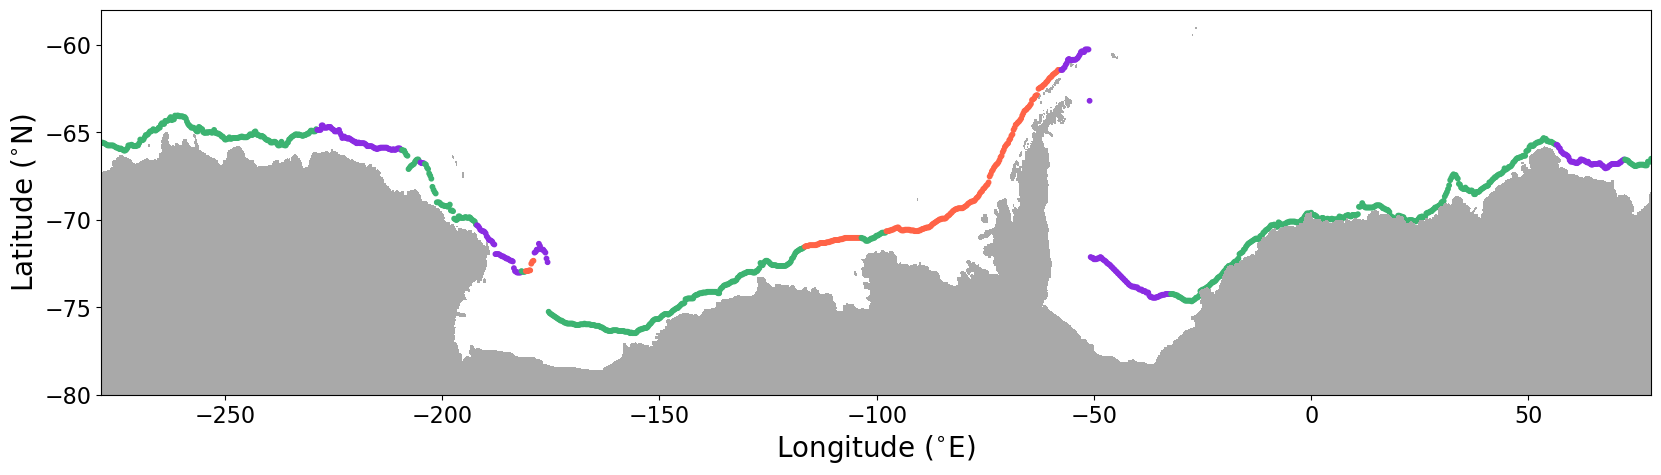

In [93]:
ft_size = 20

fig = plt.figure(figsize=(20, 5))

sc = plt.scatter(u_along.lon_bin_midpoints, u_along.lat_bin_midpoints.mean('time'), c=ASC_regimes, cmap=CustomCmap_no3, s=10)

plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.xlim(u_along.lon_bin_midpoints.min(), u_along.lon_bin_midpoints.max())
plt.ylim(-80, -58)  #(-82.5, -58)
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
plt.xticks(fontsize=ft_size-4)
plt.yticks(np.arange(-80, -59, 5), fontsize=ft_size-4);
plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/time_mean_regime_definitions.png', dpi=300, bbox_inches='tight')

In [9]:
# Average U_along into daily and monthly fields
u_along_da_daily = u_along.u_along_contour_binned.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})
CSHT_daily = ((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

u_along_da_monthly = u_along.resample(time='1M').mean().u_along_contour_binned.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

In [10]:
%%time
u_along_da_daily.load()
CSHT_months.load()
CSHT_daily.load()
u_along_da_monthly.load()

CPU times: user 47.3 s, sys: 51.9 s, total: 1min 39s
Wall time: 1min 38s


<xarray.DataArray 'u_along_contour_binned' (time: 732, depth: 75, lon: 1428)>
array([[[-0.02359511, -0.02475564, -0.02657239, ..., -0.0204653 ,
         -0.02053152, -0.02350026],
        [-0.01865366, -0.01979311, -0.02162974, ..., -0.01303114,
         -0.01375674, -0.01694079],
        [-0.01603528, -0.01716227, -0.01901062, ..., -0.00900011,
         -0.0100713 , -0.01337444],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.06889385, -0.06873107, -0.06851074, ..., -0.02077237,
         -0.02169113, -0.02693162],
        [-0.06278588, -0.06240495, -0.06204439, ..., -0.01473967,
         -0.01655271, -0.02205193],
        [-0.05906674, -0.05856833, -0.05814252, ..., -0.01109173,
         -0.01338399, -0.0190114 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.0376156 , -0.03683981, -0.03611625, ..., -0.03758969,
         -0.03398371, -0.03630787],
        [-0.03121829, -0.0303874 , -0.02965705, ..., -0.0294911 ,
         -0.02702347, -0.02966545],
        [-0.02686711, -0.02600385, -0.02527127, ..., -0.02429345,
         -0.0225731 , -0.02540491],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31

In [50]:
masked_u_along_monthly = (u_along_da_monthly*regimes_time_mean).regimes_mask
masked_u_along_monthly.load()
masked_CSHT_monthly = (CSHT_months*regimes_time_mean).regimes_mask
masked_CSHT_monthly.load()
masked_u_along_daily = (u_along_da_daily*regimes_time_mean).regimes_mask
# masked_u_along_daily.load()
masked_CSHT_daily = (CSHT_daily*regimes_time_mean).regimes_mask
# masked_CSHT_daily.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 598.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 598.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [51]:
## Average over different time scales to get depth-based correlations
CSHT_annual_monthly = masked_CSHT_monthly.mean('lon').groupby('time.year').mean('time')
U_along_annual_monthly = masked_u_along_monthly.mean('lon').groupby('time.year').mean('time')

CSHT_clima_monthly = masked_CSHT_monthly.groupby('time.month').mean('time').mean('lon')
U_along_clima_monthly = masked_u_along_monthly.groupby('time.month').mean('time').mean('lon')

CSHT_layerwise_monthly = masked_CSHT_monthly.mean('lon')
U_along_layerwise_monthly = masked_u_along_monthly.mean('lon')

## Average over different time scales to get depth-based correlations
CSHT_annual_daily = masked_CSHT_daily.mean('lon').groupby('time.year').mean('time')
U_along_annual_daily = masked_u_along_daily.mean('lon').groupby('time.year').mean('time')

CSHT_clima_daily = masked_CSHT_daily.groupby('time.month').mean('time').mean('lon')
U_along_clima_daily = masked_u_along_daily.groupby('time.month').mean('time').mean('lon')

CSHT_layerwise_daily = masked_CSHT_daily.mean('lon')
U_along_layerwise_daily = masked_u_along_daily.mean('lon')

In [52]:
U_along_layerwise_monthly

<xarray.DataArray 'regimes_mask' (time: 732, depth: 75, regime: 3)>
array([[[-0.07668567,  0.0572335 , -0.05861934],
        [-0.0672155 ,  0.06045816, -0.04892684],
        [-0.06074943,  0.06263355, -0.04224542],
        ...,
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       [[-0.12429938,  0.05683445, -0.07587818],
        [-0.11227542,  0.06193765, -0.06738941],
        [-0.10479785,  0.0647558 , -0.06237082],
        ...,
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       [[-0.20018276,  0.0278176 , -0.12225633],
        [-0.18400796,  0.03446828, -0.10648008],
        [-0.17495865,  0.03828266, -0.09771363],
        ...,
...
        ...,
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       [[-0.07496964,  0.05596139, -0.05118633],
        [-0.06531898,  0.05987153, -0.04410728],
        [-0.05992692,  0.06211529, -0.0401626 ],
        ...,
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       [[-0.06766883,  0.06576414, -0.06024565],
        [-0.05651994,  0.06830895, -0.05106946],
        [-0.0492815 ,  0.07039405, -0.04568674],
        ...,
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]]])
Coordinates:
  * regime   (regime) object 'Surface' 'Reverse' 'Deep'
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31

In [53]:
slope_all_monthly = np.zeros((masked_u_along_monthly.depth.size, 3))
stderr_all_monthly = np.zeros((masked_u_along_monthly.depth.size, 3))
r_sq_all_monthly = np.zeros((masked_u_along_monthly.depth.size, 3))
slope_annual_monthly = np.zeros((masked_u_along_monthly.depth.size, 3))
stderr_annual_monthly = np.zeros((masked_u_along_monthly.depth.size, 3))
r_sq_annual_monthly = np.zeros((masked_u_along_monthly.depth.size, 3))
slope_clima_monthly = np.zeros((masked_u_along_monthly.depth.size, 3))
stderr_clima_monthly = np.zeros((masked_u_along_monthly.depth.size, 3))
r_sq_clima_monthly = np.zeros((masked_u_along_monthly.depth.size, 3))
pval_all_monthly = np.zeros((masked_u_along_monthly.depth.size, 3))
pval_annual_monthly = np.zeros((masked_u_along_monthly.depth.size, 3))
pval_clima_monthly = np.zeros((masked_u_along_monthly.depth.size, 3))

for i in range(3):
    for j in range(masked_u_along_monthly.depth.size):
        slope_all_monthly[j,i] = stats.linregress(U_along_layerwise_monthly[:,j,i][~np.isnan(CSHT_layerwise_monthly[:,j,i])], CSHT_layerwise_monthly[:,j,i][~np.isnan(CSHT_layerwise_monthly[:,j,i])]/1e12).slope
        stderr_all_monthly[j,i] = stats.linregress(U_along_layerwise_monthly[:,j,i][~np.isnan(CSHT_layerwise_monthly[:,j,i])], CSHT_layerwise_monthly[:,j,i][~np.isnan(CSHT_layerwise_monthly[:,j,i])]/1e12).stderr
        r_sq_all_monthly[j,i] = stats.linregress(U_along_layerwise_monthly[:,j,i][~np.isnan(CSHT_layerwise_monthly[:,j,i])], CSHT_layerwise_monthly[:,j,i][~np.isnan(CSHT_layerwise_monthly[:,j,i])]/1e12).rvalue**2
        pval_all_monthly[j,i] = 1-stats.linregress(U_along_layerwise_monthly[:,j,i][~np.isnan(CSHT_layerwise_monthly[:,j,i])], CSHT_layerwise_monthly[:,j,i][~np.isnan(CSHT_layerwise_monthly[:,j,i])]/1e12).pvalue
        slope_annual_monthly[j,i] = stats.linregress(U_along_annual_monthly[:,j,i][~np.isnan(CSHT_annual_monthly[:,j,i])], CSHT_annual_monthly[:,j,i][~np.isnan(CSHT_annual_monthly[:,j,i])]/1e12).slope
        stderr_annual_monthly[j,i] = stats.linregress(U_along_annual_monthly[:,j,i][~np.isnan(CSHT_annual_monthly[:,j,i])], CSHT_annual_monthly[:,j,i][~np.isnan(CSHT_annual_monthly[:,j,i])]/1e12).stderr
        r_sq_annual_monthly[j,i] = stats.linregress(U_along_annual_monthly[:,j,i][~np.isnan(CSHT_annual_monthly[:,j,i])], CSHT_annual_monthly[:,j,i][~np.isnan(CSHT_annual_monthly[:,j,i])]/1e12).rvalue**2
        pval_annual_monthly[j,i] = 1-stats.linregress(U_along_annual_monthly[:,j,i][~np.isnan(CSHT_annual_monthly[:,j,i])], CSHT_annual_monthly[:,j,i][~np.isnan(CSHT_annual_monthly[:,j,i])]/1e12).pvalue
        slope_clima_monthly[j,i] = stats.linregress(U_along_clima_monthly[:,j,i][~np.isnan(CSHT_clima_monthly[:,j,i])], CSHT_clima_monthly[:,j,i][~np.isnan(CSHT_clima_monthly[:,j,i])]/1e12).slope
        stderr_clima_monthly[j,i] = stats.linregress(U_along_clima_monthly[:,j,i][~np.isnan(CSHT_clima_monthly[:,j,i])], CSHT_clima_monthly[:,j,i][~np.isnan(CSHT_clima_monthly[:,j,i])]/1e12).stderr
        r_sq_clima_monthly[j,i] = stats.linregress(U_along_clima_monthly[:,j,i][~np.isnan(CSHT_clima_monthly[:,j,i])], CSHT_clima_monthly[:,j,i][~np.isnan(CSHT_clima_monthly[:,j,i])]/1e12).rvalue**2
        pval_clima_monthly[j,i] = 1-stats.linregress(U_along_clima_monthly[:,j,i][~np.isnan(CSHT_clima_monthly[:,j,i])], CSHT_clima_monthly[:,j,i][~np.isnan(CSHT_clima_monthly[:,j,i])]/1e12).pvalue


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


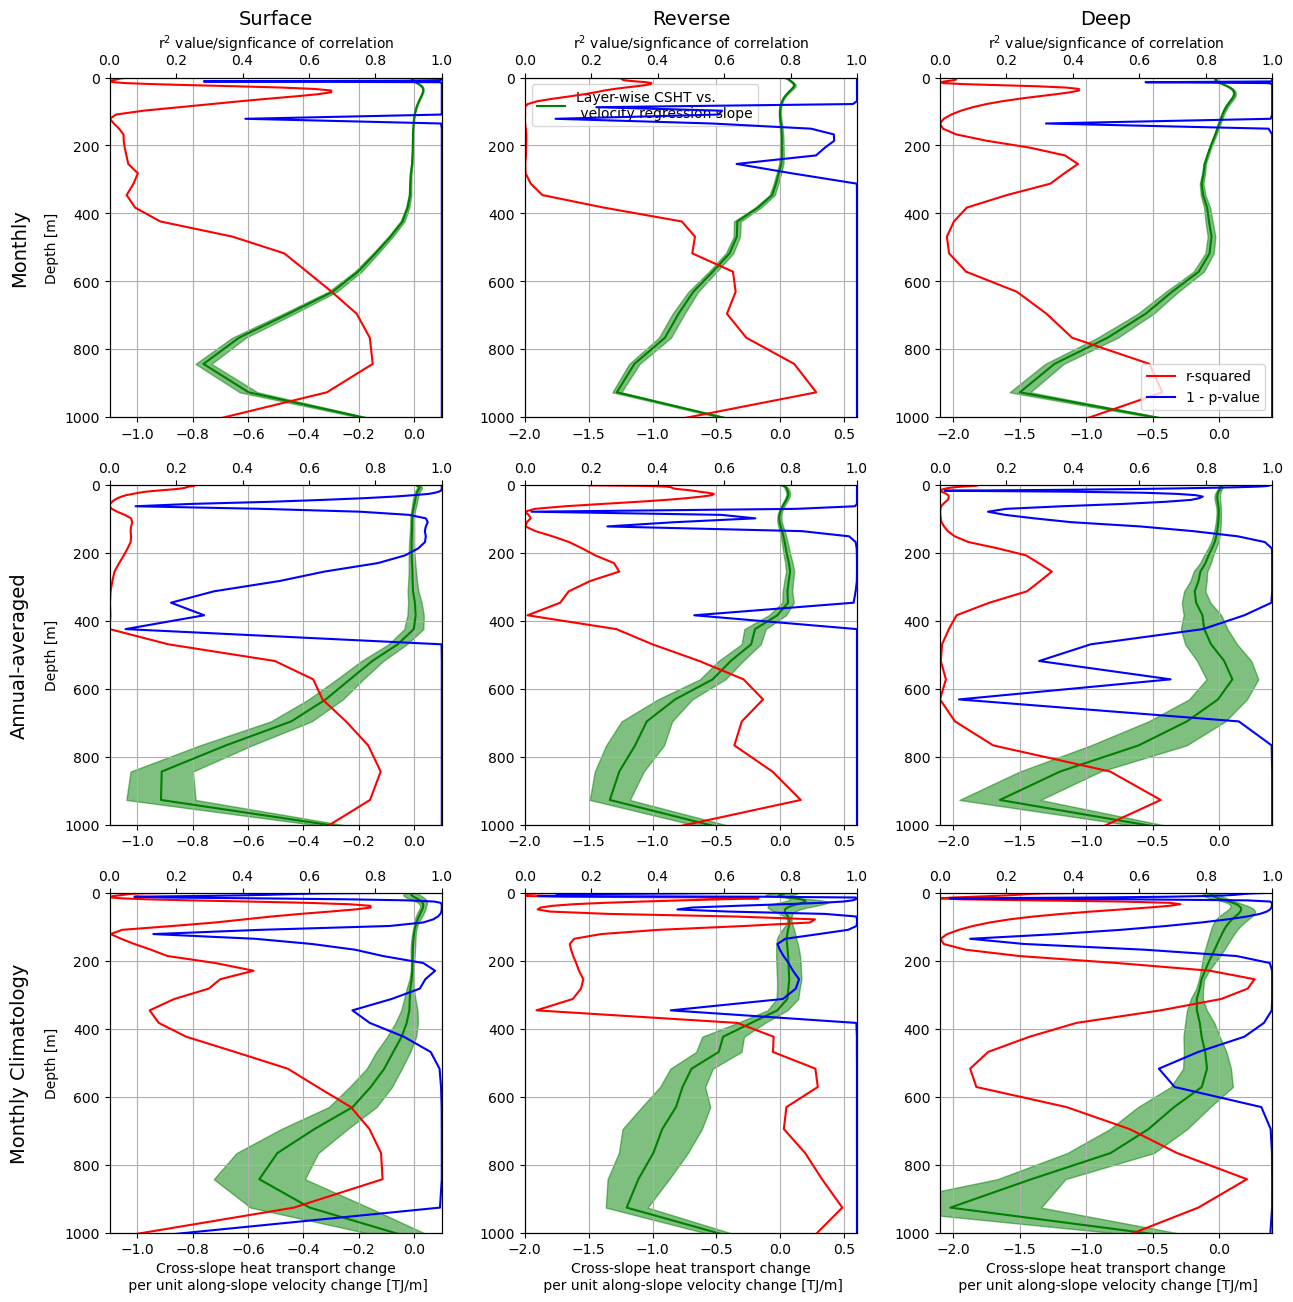

In [54]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

for i in range(3):
    axs[i+3].plot(slope_annual_monthly[:,i], masked_u_along_monthly.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+3].fill_betweenx( masked_u_along_monthly.depth,  slope_annual_monthly[:,i]-stderr_annual_monthly[:,i]*2, slope_annual_monthly[:,i]+stderr_annual_monthly[:,i]*2, alpha=0.5, color='green')
    axs[i].plot(slope_all_monthly[:,i], masked_u_along_monthly.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].fill_betweenx( masked_u_along_monthly.depth,  slope_all_monthly[:,i]-stderr_all_monthly[:,i]*2, slope_all_monthly[:,i]+stderr_all_monthly[:,i]*2, alpha=0.5, color='green')
    axs[i+6].plot(slope_clima_monthly[:,i], masked_u_along_monthly.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].fill_betweenx(masked_u_along_monthly.depth, slope_clima_monthly[:,i]-stderr_clima_monthly[:,i]*2, slope_clima_monthly[:,i]+stderr_clima_monthly[:,i]*2, alpha=0.5, color='green')

    axs[i].set_title(regimes_monthly.regime.values[i], fontsize=14)
    ax1 = axs[i].twiny()
    ax2 = axs[i+3].twiny()
    ax3 = axs[i+6].twiny()

    ax1.set_xlim(0,1)
    ax1.set_ylim(1000,0)
    ax1.set_xlabel('r$^2$ value/signficance of correlation')
    ax1.plot(r_sq_all_monthly[:,i], masked_u_along_monthly.depth, 'r', label = 'r-squared')
    ax1.plot(pval_all_monthly[:,i], masked_u_along_monthly.depth, 'b', label = '1 - p-value')
    ax2.set_xlim(0,1)
    ax2.set_ylim(1000,0)
    ax2.plot(r_sq_annual_monthly[:,i], masked_u_along_monthly.depth, 'r', label = 'r-squared')
    ax2.plot(pval_annual_monthly[:,i], masked_u_along_monthly.depth, 'b', label = '1 - p-value')
    ax3.set_xlim(0,1)
    ax3.set_ylim(1000,0)
    ax3.plot(r_sq_clima_monthly[:,i], masked_u_along_monthly.depth, 'r', label = 'r-squared')
    ax3.plot(pval_clima_monthly[:,i], masked_u_along_monthly.depth, 'b', label = '1 - p-value')

    axs[0].set_ylabel('Depth [m]')
    axs[3].set_ylabel('Depth [m]')
    axs[6].set_ylabel('Depth [m]')

    axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    axs[3*i].set_xlim(-1.1,0.1)
    axs[3*i+1].set_xlim(-2,0.6)
    axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+3].invert_yaxis()
    axs[i+3].set_ylim(1000,0)
    axs[i+3].grid()
    axs[i+6].invert_yaxis()
    axs[i+6].set_ylim(1000,0)
    axs[i+6].grid()
    axs[1].legend()

axs[0].text(-0.3,0.5, 'Monthly', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[6].text(-0.3,0.5, 'Monthly Climatology', fontsize = 14, rotation=90, va= 'center', transform = axs[6].transAxes)
axs[3].text(-0.3,0.5, 'Annual-averaged', fontsize = 14, rotation=90, va= 'center', transform = axs[3].transAxes)

ax1.legend(loc=4)
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/layer_wise_CSHT_vs_U_corr_w_zonalconv.png', bbox_inches='tight', dpi=300)
plt.show()

In [44]:
# slope_all_daily = np.zeros((masked_u_along_daily.depth.size, 3))
# stderr_all_daily = np.zeros((masked_u_along_daily.depth.size, 3))
# r_sq_all_daily = np.zeros((masked_u_along_daily.depth.size, 3))
# slope_annual_daily = np.zeros((masked_u_along_daily.depth.size, 3))
# stderr_annual_daily = np.zeros((masked_u_along_daily.depth.size, 3))
# r_sq_annual_daily = np.zeros((masked_u_along_daily.depth.size, 3))
# slope_clima_daily = np.zeros((masked_u_along_daily.depth.size, 3))
# stderr_clima_daily = np.zeros((masked_u_along_daily.depth.size, 3))
# r_sq_clima_daily = np.zeros((masked_u_along_daily.depth.size, 3))
# pval_all_daily = np.zeros((masked_u_along_daily.depth.size, 3))
# pval_annual_daily = np.zeros((masked_u_along_daily.depth.size, 3))
# pval_clima_daily = np.zeros((masked_u_along_daily.depth.size, 3))

# for i in range(3):
#     for j in range(masked_u_along_monthly.depth.size):
#         slope_all_daily[j,i] = stats.linregress(U_along_layerwise_daily[:,j,i][~np.isnan(CSHT_layerwise_daily[:,j,i])], CSHT_layerwise_daily[:,j,i][~np.isnan(CSHT_layerwise_daily[:,j,i])]/1e12).slope
#         stderr_all_daily[j,i] = stats.linregress(U_along_layerwise_daily[:,j,i][~np.isnan(CSHT_layerwise_daily[:,j,i])], CSHT_layerwise_daily[:,j,i][~np.isnan(CSHT_layerwise_daily[:,j,i])]/1e12).stderr
#         r_sq_all_daily[j,i] = stats.linregress(U_along_layerwise_daily[:,j,i][~np.isnan(CSHT_layerwise_daily[:,j,i])], CSHT_layerwise_daily[:,j,i][~np.isnan(CSHT_layerwise_daily[:,j,i])]/1e12).rvalue**2
#         pval_all_daily[j,i] = 1-stats.linregress(U_along_layerwise_daily[:,j,i][~np.isnan(CSHT_layerwise_daily[:,j,i])], CSHT_layerwise_daily[:,j,i][~np.isnan(CSHT_layerwise_daily[:,j,i])]/1e12).pvalue
#         slope_annual_daily[j,i] = stats.linregress(U_along_annual_daily[:,j,i][~np.isnan(CSHT_annual_daily[:,j,i])], CSHT_annual_daily[:,j,i][~np.isnan(CSHT_annual_daily[:,j,i])]/1e12).slope
#         stderr_annual_daily[j,i] = stats.linregress(U_along_annual_daily[:,j,i][~np.isnan(CSHT_annual_daily[:,j,i])], CSHT_annual_daily[:,j,i][~np.isnan(CSHT_annual_daily[:,j,i])]/1e12).stderr
#         r_sq_annual_daily[j,i] = stats.linregress(U_along_annual_daily[:,j,i][~np.isnan(CSHT_annual_daily[:,j,i])], CSHT_annual_daily[:,j,i][~np.isnan(CSHT_annual_daily[:,j,i])]/1e12).rvalue**2
#         pval_annual_daily[j,i] = 1-stats.linregress(U_along_annual_daily[:,j,i][~np.isnan(CSHT_annual_daily[:,j,i])], CSHT_annual_daily[:,j,i][~np.isnan(CSHT_annual_daily[:,j,i])]/1e12).pvalue
#         slope_clima_daily[j,i] = stats.linregress(U_along_clima_daily[:,j,i][~np.isnan(CSHT_clima_daily[:,j,i])], CSHT_clima_daily[:,j,i][~np.isnan(CSHT_clima_daily[:,j,i])]/1e12).slope
#         stderr_clima_daily[j,i] = stats.linregress(U_along_clima_daily[:,j,i][~np.isnan(CSHT_clima_daily[:,j,i])], CSHT_clima_daily[:,j,i][~np.isnan(CSHT_clima_daily[:,j,i])]/1e12).stderr
#         r_sq_clima_daily[j,i] = stats.linregress(U_along_clima_daily[:,j,i][~np.isnan(CSHT_clima_daily[:,j,i])], CSHT_clima_daily[:,j,i][~np.isnan(CSHT_clima_daily[:,j,i])]/1e12).rvalue**2
#         pval_clima_daily[j,i] = 1-stats.linregress(U_along_clima_daily[:,j,i][~np.isnan(CSHT_clima_daily[:,j,i])], CSHT_clima_daily[:,j,i][~np.isnan(CSHT_clima_daily[:,j,i])]/1e12).pvalue


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 17.77 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-01-18 12:01:18,551 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/protocol/core.py", line 109, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/msgpack/__init__.py", line 38, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 294, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 300, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 297, in msgpack._cmsgpack.Packer.pack


CancelledError: ('invert-6d897e5879036bd86960caea7e09d82d', 0)